### Notebook for submission 68:

# **Stats or Facts: Decomposing Generalization in Language Models with Small-Scale Models**
## ICML 2025 - MOSS workshop

This notebook replicates the key experiments from the paper:

1. Statistical, positional, and factual accuracy heatmaps across training time and diversity (Fig. 2),
2. Stagewise learning dynamics (Fig. 3), and
3. Diversity versus training-time trade-off (Fig. 4).

The paper's figures were generated using 3 runs with $N=10$ templates, $K=100$ facts and $50$k training iterations. This full setup takes over 3 hours to run for all diversity values. Sp we use a smaller scale setup here that replicates the same results but runs faster.  

To reduce runtime while preserving the main results, we use a smaller-scale setup here: $N=5$ templates, $K=10$ facts, and $15$k training iterations, running each experiment only once.


In [ ]:
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR



import torch
import gc
import os
import sys
import math
import json
import numpy as np
# from argparse import Namespace
from types import SimpleNamespace
import time
import inspect
import logging

from itertools import product
from collections import defaultdict





import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Path setup
**TO DO**: setup the path to the directory of src files

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = '/content/drive/My Drive/MCPos_exps/'
path = ... # set the path to the directory of the src folder
# %cd $path


Mounted at /content/drive
/content/drive/My Drive/MCPos_exps


In [ ]:
from src.utils import get_args, format_hyperparams, make_json_compatible, Logger, raise_and_log_error
from src.data import MarkovKnowledgeGenerator
from src.model_base import GPTBase
from src.train_utils import train

# Hyper parameters

Hyper-params for the data and model setup:

`template_mode` specifies the contextual structure. Choose

1. `='MC'` for `MCNPos1` experiment.
2. `='Pos'` for `MC1PosN` experiment.
3. `='MCPos'` for `MCNPosN` experiment.

Set `N` (number of templates) by assigning the desired value to `num_tmpl`.

The default setting is `MC5Pos5`, which runs under 2 hours.

In [ ]:
# ------- data and model setup --------------------------------------------------------------------
# change these for changing the data and model structure
args = SimpleNamespace(
    # ---------------- data hyper-params -------------------------
    K = 10,                           # fact pairs
    V_mc = 3,                         # number of generic tokens
    seq_len = 50,                     # length of the sequence
    template_mode = 'MCPos',          # options: 1) MCPos for MCNPosN, 2) MC for MCNPos1, 3) Pos for MC1PosN
    num_tmpl = 5,                     # number of templates
    ood_frac = 0.2,                   # 1 - DIV (fraction of the templates kept as OOD)
    test_size = 100,
    # ---------- model ---------------
    n_layer = 4,
    n_head = 4,
    n_embd = 32,
    # -------- training -------
    lr = 1e-4,
    num_iters = 15_000,
    batch_size = 64,
    num_ckpt=50,
    # ------------misc -----------------
    device = "cuda" if torch.cuda.is_available() else "cpu",
    results_base_folder = "./exps",   # optional: mount Drive
)
args.V = int(args.V_mc + args.K*2)
args.order = 1


# --------------------------------------------------------------------------------------------------------
if args.template_mode == 'MCPos':
    args.num_chain_tmpl = args.num_tmpl
    args.num_pos_tmpl = args.num_tmpl
    args.chain_per_pos = 1
elif args.template_mode == "MC":
    args.num_chain_tmpl = args.num_tmpl
    args.num_pos_tmpl = 1
    args.chain_per_pos = 1
elif args.template_mode == "Pos":
    args.num_chain_tmpl = 1
    args.num_pos_tmpl = args.num_tmpl
    args.chain_per_pos = 1
# -------------------------------------------------------------------------------------------

# remaining hyper-params (set as default)
args.ood_struct_eval = False
args.log_path = None   # will be filled by main()
args.ckpt_path = None
args.dtype = torch.float16
args.initial = 'stationary'
args.bi_pos = "random"
args.insertion_mode = "shift"
args.skip_spectok = True
args.rpe = True
args.model = 'base'
args.use_pretrained = "none"
args.dropout = 0.1
args.context_length = 128
args.bias = False
args.no_compile = False
args.init_value = 1.0
args.memory = -1
args.weight_decay = 1e-3
args.beta1 = 0.9
args.beta2 = 0.95
args.scheduler = 'step'
args.opt = 'adamw'
args.warmup_percent = 0.02
args.div_factor = 1e0
args.final_div_factor = 1e0
args.grad_clip = 0.0

# special tokens
if args.skip_spectok:
    PAD = None
    args.vocab_size = args.V
    args.special_toks = {'PAD':-1}
else:
    PAD = args.V
    BOS = args.V + 1
    EOS = args.V + 2
    args.vocab_size = args.V + 3
    args.special_toks = {'PAD': PAD, 'BOS':BOS, 'EOS':EOS}

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True



# ------------------- logger ----------------------------------------------------------------------
# ckpt_path = os.path.join(args.results_base_folder, exp_name)
ckpt_path = args.results_base_folder
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path)

log_path = os.path.join(args.results_base_folder, 'log.txt')
logger = Logger(log_file=log_path, level=logging.DEBUG, log_to_console=False)
args.log_path = log_path
args.ckpt_path = ckpt_path

# saving hyper-params:
filtered_args = {k: v for k, v in vars(args).items() if k not in ['device', 'dtype']}
hp_path = os.path.join(args.results_base_folder, 'hyperparams.json')
with open(hp_path, 'w') as json_file:
    json.dump(filtered_args, json_file, indent=4, default=make_json_compatible)
logger.info(f'logging setup done: saving in f{ckpt_path}')
print(f'logging setup done: saving in f{ckpt_path}')



INFO:src.utils:logging setup done: saving in f./exps


logging setup done: saving in f./exps


# Training loop

Trains a transformer model on the synthetic data for different diversity levels of the training set

In [ ]:
# setting up params for training across different diversity values
# full run
num_tmpl = args.num_tmpl
ood_list = [i / num_tmpl for i in range(1, num_tmpl)]
print(f'List of Div values to run: {[1 - i for i in ood_list]}')

full_data_dist  = {'iter':[],
                   'ood_list': ood_list,
                   'metrics': {'in_dist':{},
                               'out_dist':{}},
                   }

full_data_dist['div_list'] = [1-i for i in full_data_dist['ood_list']]
div_list = full_data_dist['div_list']

List of Div values to run: [0.8, 0.6, 0.4, 0.19999999999999996]


In [ ]:
total_run_time = 0.0

for ood in ood_list:
    args.ood_frac = ood
    logger.info(f'Training on DIV = {1 - ood}')

    # data generator
    MCGenerator = MarkovKnowledgeGenerator(V=args.V, M=args.K, order=args.order, seq_length=args.seq_len, special_toks=args.special_toks, logger=logger,
                                    insertion_mode=args.insertion_mode, device=device, skip_sepctok=args.skip_spectok,
                                    num_chain_tmpl=args.num_chain_tmpl, initial=args.initial,
                                    num_pos_tmpl=args.num_pos_tmpl, bi_pos = args.bi_pos,
                                    ood_frac=args.ood_frac, chain_per_pos=args.chain_per_pos,
                                    )
    args.chain_tokens, _ = MCGenerator.get_MC_props()
    _, args.knowledge_tokens = MCGenerator.get_knowledge_base()


    ## ----------------------- model setup ------------------------------------------------------------------------------------
    args.no_tying = True
    model = GPTBase(args, pad_idx=PAD).to(args.device)
    group_specs = model.get_parameter_group_specs()

    # changed this part: count the params directly, not from distributed back-end
    logger.info('model loaded')

    # ----------------------- opt setup -------------------------------------------------------------------------------------------
    use_fused = (device == 'cuda') and ('fused' in inspect.signature(torch.optim.AdamW).parameters)

    extra_args = dict(fused=True) if use_fused else dict()
    opt = torch.optim.AdamW(group_specs, lr=args.lr, betas=(args.beta1, args.beta2),
                            weight_decay=args.weight_decay, **extra_args)

    scheduler = StepLR(opt, step_size=3000, gamma=1.0) # gamma=1.0 -> constant learning rate!


    # ----------------------- training setup -----------------------------------------------------------------------------------------
    t_start = time.time()
    ckpts = train(model, opt, MCGenerator, scheduler, args, logger)

    # saving and final logs:
    logger.info(f'Training done on DIV =  {1 - ood}')
    logger.info(f'Total run time: {(time.time()-t_start)/60}min')
    logger.info(f'-'*200)
    total_run_time += (time.time()-t_start)/60

    # ------ aggregating data ------------------
    mode_list = ['in_dist', 'out_dist']
    if len(full_data_dist['iter']) == 0:
        full_data_dist['iter'] = ckpts['iter']

        metric_list = ckpts['in_dist'].keys()
        for metric in metric_list:
            for mode in mode_list:
                full_data_dist['metrics'][mode][metric] = []

    for metric in metric_list:
        for mode in mode_list:
            full_data_dist['metrics'][mode][metric].append(ckpts[mode][metric])


# post-process of metrics
for metric in metric_list:
    for mode in mode_list:
        full_data_dist['metrics'][mode][metric] = np.array(full_data_dist['metrics'][mode][metric])


combined_metric_name = "combined_non_kb_and_kb_at_pos"
for mode in mode_list:
    full_data_dist['metrics'][mode]["non_kb_token_count_outside_reserved"] = full_data_dist['metrics'][mode]["non_kb_token_count_outside_reserved"] / (args.seq_len//2-1)
    full_data_dist['metrics'][mode]["combined_non_kb_and_kb_at_pos"] = (full_data_dist['metrics'][mode]["non_kb_token_count_outside_reserved"] +
                        full_data_dist['metrics'][mode]["at_pos_is_kb_rate"]) / 2


    full_data_dist['metrics'][mode]["non_kb_outside_reserved_loss"] = full_data_dist['metrics'][mode]["non_kb_outside_reserved_loss"] / (args.seq_len//2-1)
    full_data_dist['metrics'][mode]["combined_non_kb_and_kb_at_pos_loss"] = (full_data_dist['metrics'][mode]["non_kb_outside_reserved_loss"] +
                            full_data_dist['metrics'][mode]["at_pos_kb_loss"]) / 2



logger.info(f'Total run time: {total_run_time}min')



INFO:src.utils:Training on DIV = 0.8


INFO:src.utils:model loaded
INFO:src.utils:0 [in-dist] loss=3.090 [time per itr] 0.00ms [time per eval itr] 2597.26ms [lr] 0.00010
INFO:src.utils:5 [in-dist] loss=2.904 [time per itr] 16.40ms [time per eval itr] 805.03ms [lr] 0.00010
INFO:src.utils:15 [in-dist] loss=2.762 [time per itr] 17.83ms [time per eval itr] 926.19ms [lr] 0.00010
INFO:src.utils:41 [in-dist] loss=2.633 [time per itr] 16.32ms [time per eval itr] 900.14ms [lr] 0.00010
INFO:src.utils:111 [in-dist] loss=2.334 [time per itr] 15.89ms [time per eval itr] 1013.68ms [lr] 0.00010
INFO:src.utils:296 [in-dist] loss=1.692 [time per itr] 28.42ms [time per eval itr] 1607.62ms [lr] 0.00010
INFO:src.utils:790 [in-dist] loss=1.155 [time per itr] 17.70ms [time per eval itr] 1989.54ms [lr] 0.00010
INFO:src.utils:2107 [in-dist] loss=0.929 [time per itr] 15.62ms [time per eval itr] 2031.98ms [lr] 0.00010
INFO:src.utils:5622 [in-dist] loss=0.860 [time per itr] 15.82ms [time per eval itr] 2031.74ms [lr] 0.00010
INFO:src.utils:14999 [in-d

INFO:src.utils:0 [in-dist] loss=3.164 [time per itr] 0.00ms [time per eval itr] 1024.92ms [lr] 0.00010
INFO:src.utils:5 [in-dist] loss=2.971 [time per itr] 26.27ms [time per eval itr] 788.06ms [lr] 0.00010
INFO:src.utils:15 [in-dist] loss=2.805 [time per itr] 17.61ms [time per eval itr] 871.31ms [lr] 0.00010
INFO:src.utils:41 [in-dist] loss=2.664 [time per itr] 17.21ms [time per eval itr] 903.00ms [lr] 0.00010
INFO:src.utils:111 [in-dist] loss=2.341 [time per itr] 17.44ms [time per eval itr] 1045.32ms [lr] 0.00010
INFO:src.utils:296 [in-dist] loss=1.700 [time per itr] 22.50ms [time per eval itr] 1933.39ms [lr] 0.00010
INFO:src.utils:790 [in-dist] loss=1.252 [time per itr] 19.05ms [time per eval itr] 2035.24ms [lr] 0.00010
INFO:src.utils:2107 [in-dist] loss=1.033 [time per itr] 15.59ms [time per eval itr] 2023.48ms [lr] 0.00010
INFO:src.utils:5622 [in-dist] loss=0.947 [time per itr] 16.99ms [time per eval itr] 2259.02ms [lr] 0.00010
INFO:src.utils:14999 [in-dist] loss=0.921 [time per it

INFO:src.utils:0 [in-dist] loss=3.101 [time per itr] 0.00ms [time per eval itr] 767.97ms [lr] 0.00010
INFO:src.utils:5 [in-dist] loss=2.954 [time per itr] 23.55ms [time per eval itr] 1036.28ms [lr] 0.00010
INFO:src.utils:15 [in-dist] loss=2.813 [time per itr] 17.14ms [time per eval itr] 837.90ms [lr] 0.00010
INFO:src.utils:41 [in-dist] loss=2.680 [time per itr] 16.01ms [time per eval itr] 902.97ms [lr] 0.00010
INFO:src.utils:111 [in-dist] loss=2.358 [time per itr] 15.68ms [time per eval itr] 1016.22ms [lr] 0.00010
INFO:src.utils:296 [in-dist] loss=1.710 [time per itr] 16.27ms [time per eval itr] 1454.04ms [lr] 0.00010
INFO:src.utils:790 [in-dist] loss=1.166 [time per itr] 24.81ms [time per eval itr] 1948.30ms [lr] 0.00010
INFO:src.utils:2107 [in-dist] loss=0.952 [time per itr] 15.40ms [time per eval itr] 2014.50ms [lr] 0.00010
INFO:src.utils:5622 [in-dist] loss=0.858 [time per itr] 17.76ms [time per eval itr] 2044.76ms [lr] 0.00010
INFO:src.utils:14999 [in-dist] loss=0.833 [time per it

INFO:src.utils:0 [in-dist] loss=3.053 [time per itr] 0.00ms [time per eval itr] 802.34ms [lr] 0.00010
INFO:src.utils:5 [in-dist] loss=2.911 [time per itr] 20.42ms [time per eval itr] 1127.75ms [lr] 0.00010
INFO:src.utils:15 [in-dist] loss=2.800 [time per itr] 15.89ms [time per eval itr] 855.37ms [lr] 0.00010
INFO:src.utils:41 [in-dist] loss=2.668 [time per itr] 21.75ms [time per eval itr] 1219.76ms [lr] 0.00010
INFO:src.utils:111 [in-dist] loss=2.349 [time per itr] 17.65ms [time per eval itr] 1235.84ms [lr] 0.00010
INFO:src.utils:296 [in-dist] loss=1.709 [time per itr] 17.25ms [time per eval itr] 1472.31ms [lr] 0.00010
INFO:src.utils:790 [in-dist] loss=1.234 [time per itr] 16.79ms [time per eval itr] 2386.96ms [lr] 0.00010
INFO:src.utils:2107 [in-dist] loss=0.999 [time per itr] 20.59ms [time per eval itr] 2549.04ms [lr] 0.00010
INFO:src.utils:5622 [in-dist] loss=0.911 [time per itr] 16.68ms [time per eval itr] 2013.23ms [lr] 0.00010
INFO:src.utils:14999 [in-dist] loss=0.896 [time per i

# Plots

`heatmaps` generates Fig. 2

`stages` generates Fig. 3

`div_tradeoff` generates Fig. 4

In [ ]:
plot_modes = ['in_dist', 'out_dist']
plot_list = ['heatmaps', 'div_tradeoff', 'stages']

In [ ]:
# plotting setup

selected_metrics = ["at_pos_is_bi_rate",
                    'kl_masked_completion_GT',
                    'combined_non_kb_and_kb_at_pos',
                    ]


vmin_dict = {"at_pos_is_bi_rate": 0.0,'at_pos_bi_loss': 0.0,
            'combined_non_kb_and_kb_at_pos': 0.0, 'combined_non_kb_and_kb_at_pos_loss':0.0,
            'kl_masked_completion_GT':0.0, }

vmax_dict = {"at_pos_is_bi_rate": 1.0,'at_pos_bi_loss': 1.0,
            'combined_non_kb_and_kb_at_pos': 1.0, 'combined_non_kb_and_kb_at_pos_loss':1.0,
            'kl_masked_completion_GT':0.8, }


legend_dict = {"at_pos_is_bi_rate":  r'$\mathtt{Acc}_{\mathrm{fact}}$', 'at_pos_bi_loss': r'$\mathtt{Loss}_{\mathrm{fact}}$',
                'kl_masked_completion_GT':r'$\mathtt{Loss}_{\mathrm{stat}}$',
                'combined_non_kb_and_kb_at_pos':r'$\mathtt{Acc}_{\mathrm{pos}}$', 'combined_non_kb_and_kb_at_pos_loss': r'$\mathtt{Loss}_{\mathrm{pos}}$', }


iter_list = full_data_dist['iter']
iters_to_include = list(range(len(iter_list)))

group_name = f'MC{args.num_chain_tmpl}Pos{args.num_pos_tmpl}'


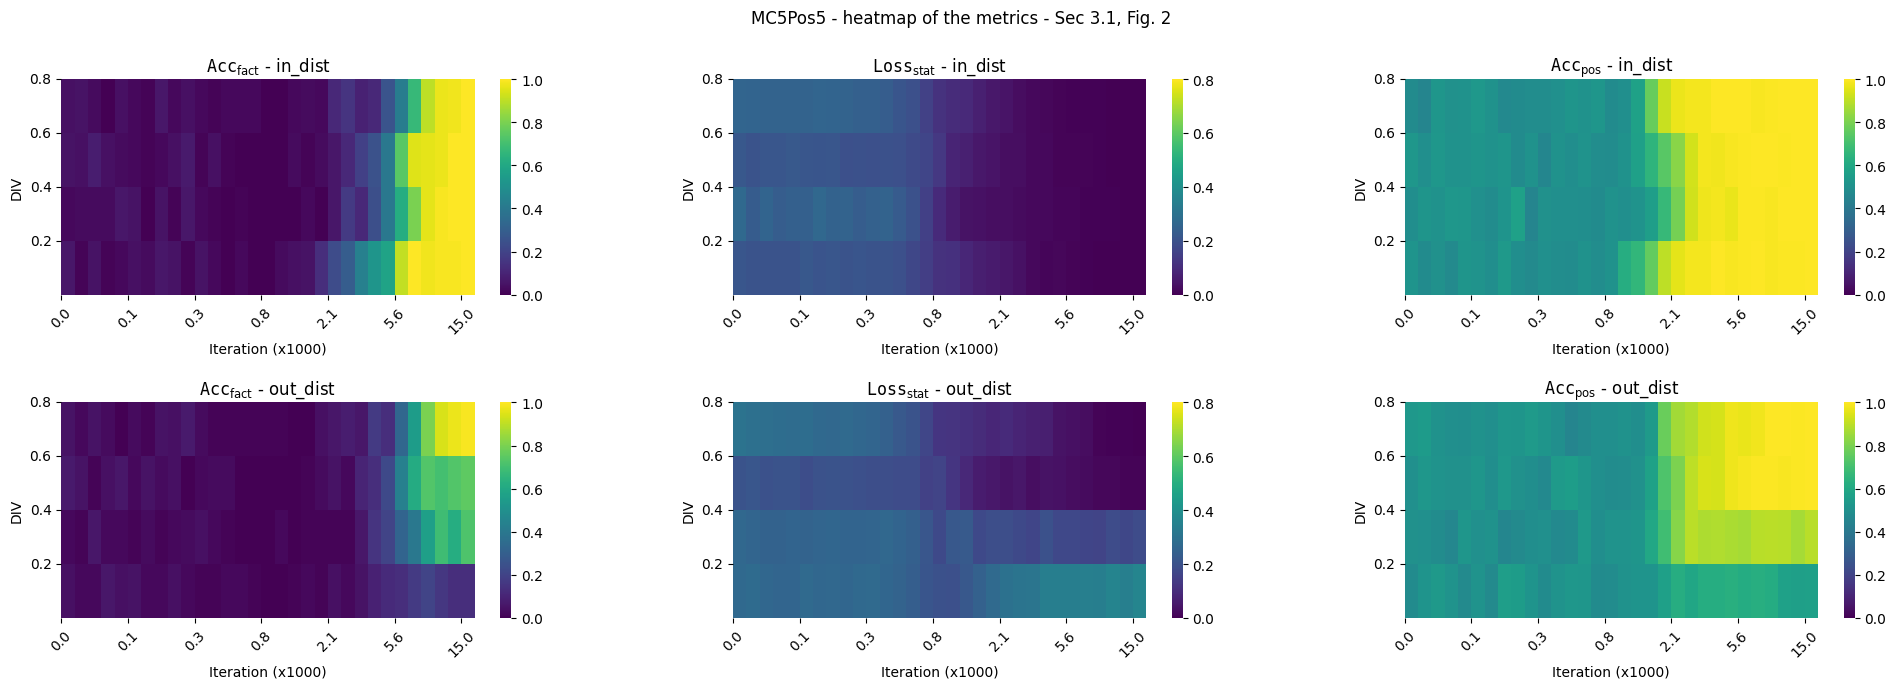

In [ ]:

iter_idx_start = len(iter_list) // 3


if 'heatmaps' in plot_list:
    nrows, ncols = (2,3)
    fig, axs = plt.subplots(nrows, ncols, figsize=(8* ncols, 3.5 * nrows), dpi=100)
    fig.subplots_adjust(wspace=0.3, hspace=0.5)
    fig.suptitle(f'{group_name} - heatmap of the metrics - Sec 3.1, Fig. 2')

    for jm, m in enumerate(selected_metrics):
        for j, mode in enumerate(plot_modes):
            matrix = full_data_dist['metrics'][mode][m]
            vmin = vmin_dict[m]
            vmax = vmax_dict[m]

            cbar_ = True
            sns.heatmap(matrix[:,iter_idx_start:], ax=axs[j,jm], cmap='viridis', cbar=cbar_,
                        norm=mcolors.PowerNorm(gamma=1.0, vmin=vmin, vmax=vmax),
                        )
            axs[j,jm].tick_params(axis='both', labelsize=10)
            axs[j,jm].tick_params(axis='both')


            # Set x-ticks (columns: iterations)
            xticks = np.arange(0, len(iters_to_include[iter_idx_start:]), 5)
            axs[j,jm].set_xticks(xticks)
            axs[j,jm].set_xticklabels([f"{iter_list[it]/1000:.1f}" for it in iters_to_include][iter_idx_start::5], rotation=45)

            # Set y-ticks (rows: div_list)
            yticks = np.arange(0, len(div_list), 1)
            axs[j,jm].set_yticks(yticks)
            axs[j,jm].set_yticklabels([f"{f:.1f}" for f in div_list][::1], rotation=0)

            axs[j,jm].set_title(f"{legend_dict[m]} - {mode}")
            axs[j,jm].set_xlabel("Iteration (x1000)")
            axs[j,jm].set_ylabel("DIV")
            axs[j,jm].tick_params(axis='both')

    plt.show()





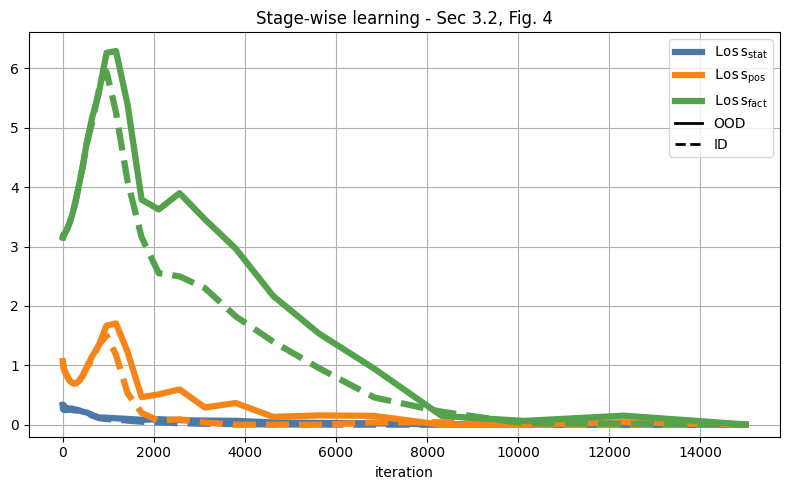

In [ ]:
stages_list = ['kl_masked_completion_GT', 'combined_non_kb_and_kb_at_pos_loss', 'at_pos_bi_loss', ]
stages_ood = full_data_dist['ood_list'][-1]

iter_idx_start = 0


if 'stages' in plot_list:
    fig, ax = plt.subplots(figsize=(8, 5))

    ood_idx, ood_val = 0, stages_ood

    iters = np.array([iter_list[it] for it in iters_to_include][iter_idx_start:])

    ax.tick_params(axis='both')
    colors = [
        '#4C78A8',  # Soft but solid blue
        '#F58518',  # Orange (warmer contrast)
        '#54A24B',  # Green (more distinct, rich)
    ]
    linestyles = {'out_dist': 'solid', 'in_dist': 'dashed'}

    for m_idx, m in enumerate(stages_list):

        color = colors[m_idx]
        for mode in ['out_dist', 'in_dist']:
            linestyle = linestyles[mode]

            mean_curve = full_data_dist['metrics'][mode][m][ood_idx, iter_idx_start:]

            label = f"{legend_dict[m]}" if mode == 'out_dist' else None
            ax.plot(iters, mean_curve, label=label, color=color, linewidth=4.5, linestyle=linestyle)

    metric_legend = ax.get_legend_handles_labels()
    custom_lines = [
        Line2D([0], [0], color='black', linestyle='solid', lw=2.0, label='OOD'),
        Line2D([0], [0], color='black', linestyle='dashed', lw=2.0, label='ID'),
    ]

    ax.legend(handles=metric_legend[0] + custom_lines)
    ax.grid(True)

    ax.set_xlabel('iteration')
    ax.set_title('Stage-wise learning - Sec 3.2, Fig. 4')

    ax.set_ylim(bottom=-0.2)
    fig.tight_layout()


    plt.show()





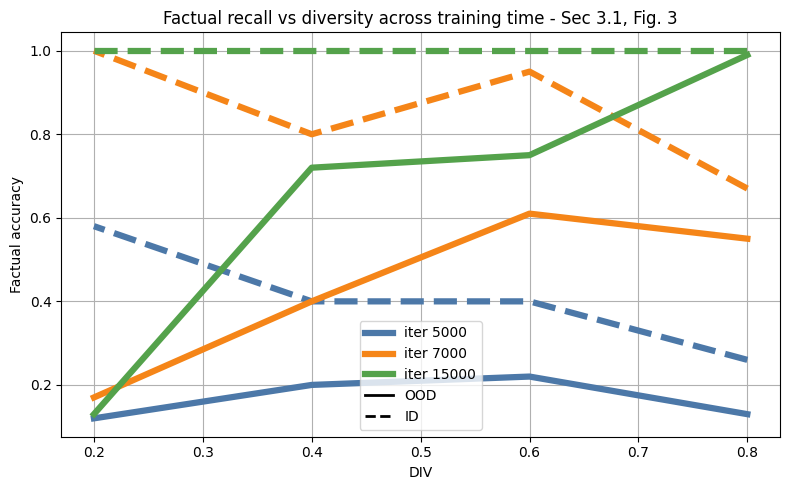

In [ ]:

div_tradeoff_list = ['at_pos_is_bi_rate']
div_tradeoff_iter_list = [-7, -5, -1]

if 'div_tradeoff' in plot_list:

    for m in div_tradeoff_list:
        fig, ax = plt.subplots(figsize=(8, 5))

        colors = [
            '#4C78A8',  # Soft but solid blue
            '#F58518',  # Orange (warmer contrast)
            '#54A24B',  # Green (more distinct, rich)
        ]
        for idx, iter_val in enumerate(div_tradeoff_iter_list):

            for mode, linestyle in zip(['out_dist', 'in_dist'], ['solid', 'dashed']):

                mean_values = full_data_dist['metrics'][mode][m][:, iter_val]

                # ax.tick_params(axis='both', labelsize=20)
                ax.tick_params(axis='both')

                label = f"iter {round(iter_list[iter_val], -3)}" if mode == 'out_dist' else None

                # label = f"{mode} - iter {iter_list[iter_val]}"
                ax.plot(div_list, mean_values, label=label,
                        linestyle=linestyle, color=colors[idx],linewidth=4.5)

        ax.set_title(f"Factual recall vs diversity across training time - Sec 3.1, Fig. 3")
        ax.set_xlabel("DIV")
        ax.set_ylabel("Factual accuracy")
        # Now add line style meaning separately
        custom_lines = [
            Line2D([0], [0], color='black', linestyle='solid', lw=2.0, label='OOD'),
            Line2D([0], [0], color='black', linestyle='dashed', lw=2.0, label='ID'),
        ]

        # Combine both parts
        metric_legend = ax.get_legend_handles_labels()

        ax.legend(handles=metric_legend[0] + custom_lines)
        ax.grid(True)

        fig.tight_layout()

        plt.show()